# Unity eye

similar to the main_project notebook but tested on the unity eye dataset.

In [2]:
import numpy as np
from skimage.color import rgb2gray
import cv2
import os
import pandas as pd

from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib.image import imread
from matplotlib.patches import Circle
%matplotlib inline

from scipy.ndimage import gaussian_filter
from scipy.ndimage import convolve
from skimage.transform import resize
from skimage.morphology import *
from skimage.feature import blob_doh
from skimage.transform import hough_circle
from skimage.feature import canny

In [3]:
#functions used in edge canny from scratch

def gaussian_smoothing(img):
    smoothed_img = gaussian_filter(img, sigma=5)
    return smoothed_img

def gradient(img):
    sobel_x = np.array([[-1, 0, 1],
                        [-2, 0, 2],
                        [-1, 0, 1]])
    sobel_y = np.array([[1, 2, 1],
                        [0, 0, 0],
                        [-1, -1, -2]])
    sobel_x_img = convolve(img, sobel_x, mode='constant')
    sobel_y_img = convolve(img, sobel_y, mode='constant')
    g_magnitude = np.sqrt(sobel_x_img ** 2 + sobel_y_img ** 2)
    g_dir = np.arctan2(sobel_x_img, sobel_y_img)
    return g_magnitude, g_dir

def non_maximum_suppression(g_magnitude, g_dir):
    g_dir[g_dir < 0] += np.pi
    g_dir_hat = np.floor_divide(g_dir, np.pi / 4)
    g_max = np.zeros_like(g_magnitude)
    for x in range(1, g_magnitude.shape[0] - 1):
        for y in range(1, g_magnitude.shape[1] - 1):
            magnitude = g_magnitude[x, y]
            dir_hat = g_dir_hat[x, y]
            if dir_hat == 0:  # east/west
                if np.greater_equal(magnitude, g_magnitude[x, y-1]) and np.greater_equal(magnitude, g_magnitude[x, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 1: #northeast/southwest
                if np.greater_equal(magnitude, g_magnitude[x+1, y-1]) and np.greater_equal(magnitude, g_magnitude[x-1, y+1]):
                    g_max[x, y] = magnitude
            elif dir_hat == 2: #nort/south
                if np.greater_equal(magnitude, g_magnitude[x+1, y]) and np.greater_equal(magnitude, g_magnitude[x-1, y]):
                    g_max[x, y] = magnitude
            elif dir_hat == 3: #nortwest/southeast
                if np.greater_equal(magnitude, g_magnitude[x+1, y+1]) and np.greater_equal(magnitude, g_magnitude[x-1, y-1]):
                    g_max[x, y] = magnitude
    return g_max

def double_thresholding(g_max, thresh_lo, thresh_hi):
    thresh_img = np.zeros_like(g_max)
    for x in range(g_max.shape[0]):
      for y in range(g_max.shape[1]):
          mag = g_max[x, y]   
          if mag > thresh_hi:
              thresh_img[x, y] = 255 #strong
          elif mag > thresh_lo:
              thresh_img[x, y] = 128 #weak
    return thresh_img

def connectivity(thresh_img):
    edge_img = np.zeros_like(thresh_img)
    for x in range(thresh_img.shape[0]):
      for y in range(thresh_img.shape[1]):
        edge = thresh_img[x,y]
        if edge == 255:
          edge_img[x,y] = edge
        if edge == 128:
          if thresh_img[x-1,y-1]==255 or thresh_img[x-1,y]==255 or thresh_img[x,y-1]==255 or thresh_img[x+1,y]==255 or thresh_img[x+1,y+1]==255:
            edge_img[x,y] = edge
    return edge_img

In [4]:
# edge canny from scratch

def canny_edge_detector(img, thresh_lo=0.01, thresh_hi=0.04):
    """
    The Canny edge detector.
    
    Inputs:
        img              The input image
        thresh_lo        The fraction of the maximum gradient magnitude which will 
                         be considered the lo threshold. 
        thresh_hi        The fraction of the maximum gradient magnitude which will
                         be considered the hi threshold. Ideally should be 2x to 3x 
                         thresh_lo.
                         
    Outputs: 
        edge_img         A binary image, with pixels lying on edges marked with a 1, 
                         and others with a 0.
    """
    
    # Smooth the image first. 
    smoothed             = gaussian_smoothing(img)
    
    # Find gradient magnitude and direction
    g_magnitude, g_dir   = gradient(smoothed)
    
    # Non-maximum suppression
    g_max                = non_maximum_suppression(g_magnitude, g_dir)
    
    # Double thresholding
    thresh_img           = double_thresholding(g_max, thresh_lo, thresh_hi)
    
    # Final edge connectivity
    edge_img             = connectivity(thresh_img)
    
    # Return the result
    return edge_img

In [5]:
# detect circles fromm scratch

def detectCircles(img,threshold,region,radius): 
    (M,N) = img.shape
    [R_max,R_min] = radius
    R = R_max - R_min
    #Initializing accumulator array.
    #Accumulator array is a 3 dimensional array with the dimensions representing
    #the radius, X coordinate and Y coordinate resectively.
    #Also appending a padding of 2 times R_max to overcome the problems of overflow
    A = np.zeros((R_max,M+2*R_max,N+2*R_max))
    B = np.zeros((R_max,M+2*R_max,N+2*R_max))

    #Precomputing all angles to increase the speed of the algorithm
    theta = np.arange(0,360)*np.pi/180
    edges = np.argwhere(img[:,:])                                               #Extracting all edge coordinates
    for val in range(R):
        r = R_min+val
        #Creating a Circle Blueprint
        bprint = np.zeros((2*(r+1),2*(r+1)))
        (m,n) = (r+1,r+1)                                                       #Finding out the center of the blueprint
        for angle in theta:
            x = int(np.round(r*np.cos(angle)))
            y = int(np.round(r*np.sin(angle)))
            bprint[m+x,n+y] = 1
        constant = np.argwhere(bprint).shape[0]
        for x,y in edges:                                                       #For each edge coordinates
            #Centering the blueprint circle over the edges
            #and updating the accumulator array
            X = [x-m+R_max,x+m+R_max]                                           #Computing the extreme X values
            Y= [y-n+R_max,y+n+R_max]                                            #Computing the extreme Y values
            A[r,X[0]:X[1],Y[0]:Y[1]] += bprint
        A[r][A[r]<threshold*constant/r] = 0

    for r,x,y in np.argwhere(A):
        temp = A[r-region:r+region,x-region:x+region,y-region:y+region]
        try:
            p,a,b = np.unravel_index(np.argmax(temp),temp.shape)
        except:
            continue
        B[r+(p-region),x+(a-region),y+(b-region)] = 1

    return B[:,R_max:-R_max,R_max:-R_max]



In [6]:
def displayCircles(image, coor):
    fig = plt.figure()
    plt.imshow(image)
    circleCoordinates = np.argwhere(coor)                                          #Extracting the circle information
    circle = []
    for r,x,y in circleCoordinates:
        circle.append(plt.Circle((y,x),r,color=(1,0,0),fill=False))
        fig.add_subplot(111).add_artist(circle[-1])
    plt.show()


In [7]:
def mask_image(gray, threshold):
    mask = gray > threshold
    return mask

In [8]:
def dilated_image(image, rep):
  dilated = dilation(image)
  for i in range(rep-1):
    dilated=dilation(dilated)
  return dilated

In [9]:
def NewdisplayCircles(image, coor, filename):
    h = image.shape[0]
    w = image.shape[1]
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image)
    # Create a circle patch with the desired coordinates and radius
    circleCoordinates = np.argwhere(coor)
    circleCoordinates = np.mean(circleCoordinates, axis=0)
    if len(circleCoordinates)==0:
        circleCoordinates=[[1,h/2,w/2]]
    r,y,x = circleCoordinates
    circle = Circle((x,y), r, color='red', fill=False)
    # Add the circle patch to the axis
    ax.add_patch(circle)
    # Save the figure
    plt.savefig(filename)
    # close the figure
    plt.close(fig)
    # read the saved file and return the image
    return plt.imread(filename)

In [10]:
def output_coor_circles(image, coor):
    circleCoordinates = np.argwhere(coor)
    circleCoordinates = np.mean(circleCoordinates, axis=0)
    return circleCoordinates 

In [11]:
def displayBlob(image, blob, filename, max_radius, min_radius):
    h = image.shape[0]
    w = image.shape[1]
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image)
    if len(blob)==0:
        blob=[[h/2,w/2,15]]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    # Save the figure
    plt.savefig(filename)
    # close the figure
    plt.close(fig)
    # read the saved file and return the image
    return plt.imread(filename)

In [12]:
def NewdisplayBlob(image, blob, filename, max_radius, min_radius):
    h = image.shape[0]
    w = image.shape[1]
    # Create a figure and axis
    fig, ax = plt.subplots()
    # Read in an image and display it on the axis
    ax.imshow(image)
    if len(blob)==0:
        blob=[np.array([np.nan, np.nan, np.nan])]
    blob = np.array(blob)
    blob = blob[(blob[:, 2] >= min_radius) & (blob[:, 2] <= max_radius)]
    blob = np.mean(blob, axis=0)
    y, x, r = blob
    c = plt.Circle((x, y), r, color='red', linewidth=2, fill=False)
    ax.add_patch(c)
    # Save the figure
    plt.savefig(filename)
    # close the figure
    plt.close(fig)
    # read the saved file and return the image
    return plt.imread(filename)



In [13]:
def New_output_coor_blob(image, blob, max_radius, min_radius):
    if len(blob)==0:
        blob=[np.array([np.nan, np.nan, np.nan])]
    blob = np.array(blob)
    blob = blob[(blob[:, 2] >= min_radius) & (blob[:, 2] <= max_radius)]
    blob = np.mean(blob, axis=0)
    return blob

In [14]:
path = 'SynthEyes_data/f01/'
files = os.listdir(path)
num_files = len(files)

In [15]:
mask = []
dilated_mask = []
dilated_mask_edge = []
coor_edge_dilated_mask = []
disp_edge_dilated_mask = []
coor_circles = []

for i in tqdm(range(len(gray))):
    mask.append(mask_image(gray[i],0.2))
    dilated_mask.append(dilated_image(mask[i], 5))
    dilated_mask_edge.append(canny_edge_detector(dilated_mask[i]).astype(np.uint8))
    coor_edge_dilated_mask.append(detectCircles(dilated_mask_edge[i],10,15,radius=[80,15]))
    # disp_edge_dilated_mask.append(NewdisplayCircles(image[i], coor_edge_dilated_mask[i], "circle_estimation/edge_dilated_mask_circle_{}.png".format(i)))
    coor_circles.append(output_coor_circles(image[i], coor_edge_dilated_mask[i]))


In [16]:
# fig, axes = plt.subplots(figsize=(50, 50), nrows=5, ncols=5,)
# axes = axes.ravel()
# # iterate through the images and display them
# for i in range(len(disp_edge_dilated_mask)):
#     axes[i].imshow(disp_edge_dilated_mask[i], cmap='gray')
#     axes[i].axis('off')

# plt.show()

dict_keys(['ldmks', 'look_vec', 'head_pose'])
look_vec:  [0.2564261257648468, 0.23161327838897705, -0.9384033679962158]
[(49.57264065742493, 41.89596891403198), (54.464231729507446, 43.562824726104736), (59.315282106399536, 41.178438663482666), (61.28401279449463, 36.13986015319824), (59.2172634601593, 31.398487091064453), (54.325772523880005, 29.731788635253906), (49.47482228279114, 32.11597442626953), (47.50596642494202, 37.154507637023926)]
54.394998997449875
36.64723128080368


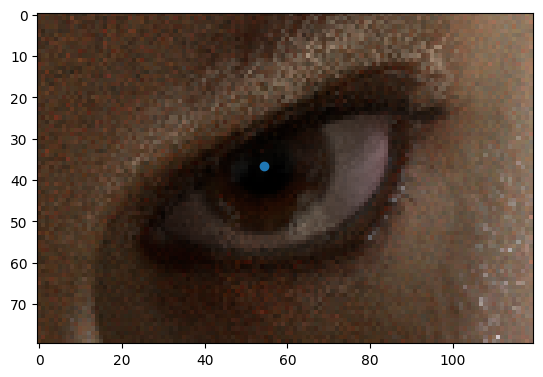

In [17]:
unpickled_df = pd.read_pickle("SynthEyes_data/f01/f01_51_-0.1963_-0.1963.pkl")  
print(unpickled_df.keys())
print('look_vec: ',unpickled_df['look_vec'])
print((unpickled_df['ldmks']['ldmks_pupil_2d']))
x_coordinates = [tup[0] for tup in unpickled_df['ldmks']['ldmks_pupil_2d']]
y_coordinates = [tup[1] for tup in unpickled_df['ldmks']['ldmks_pupil_2d']]
mean_x = sum(x_coordinates) / len(x_coordinates)
mean_y = sum(y_coordinates) / len(y_coordinates)
print(mean_x)
print(mean_y)
image = imread('SynthEyes_data/f01/f01_51_-0.1963_-0.1963.png')
plt.imshow(image)
plt.scatter(mean_x, mean_y)

In [18]:
image_reshaped = image[:,:,:-1]
gray=rgb2gray(image_reshaped)
mask=(mask_image(gray,0.2))
mask_blob=blob_doh(mask, max_sigma=20, min_sigma=5, threshold=.05)
disp_mask_blob=displayBlob(image_reshaped, mask_blob, "blob_estimation_unity.png",20, 5)
coor_blob=output_coor_blob(image_reshaped, mask_blob,20,5)
print(coor_blob[0:2])
plt.imshow(disp_mask_blob)

NameError: name 'output_coor_blob' is not defined

[38.66703304 53.82393101]


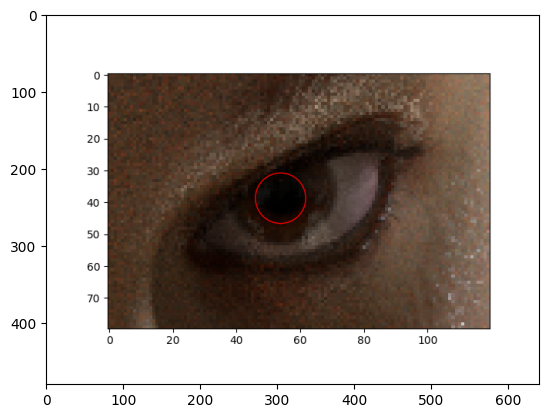

In [ ]:

mask=mask_image(gray,0.3)
dilated_mask=dilated_image(mask, 5)
dilated_mask_edge=canny(dilated_mask, sigma=3, low_threshold=0.2, high_threshold=0.4).astype(np.uint8)
coor_edge_dilated_mask=hough_circle(dilated_mask_edge, np.arange(5, 20))
disp_edge_dilated_mask=NewdisplayCircles(image_reshaped, coor_edge_dilated_mask, "unity_eye_circle_estimation.png")
coor_circles=output_coor_circles(image_reshaped, coor_edge_dilated_mask)
plt.imshow(disp_edge_dilated_mask)
print(coor_circles[1:3])

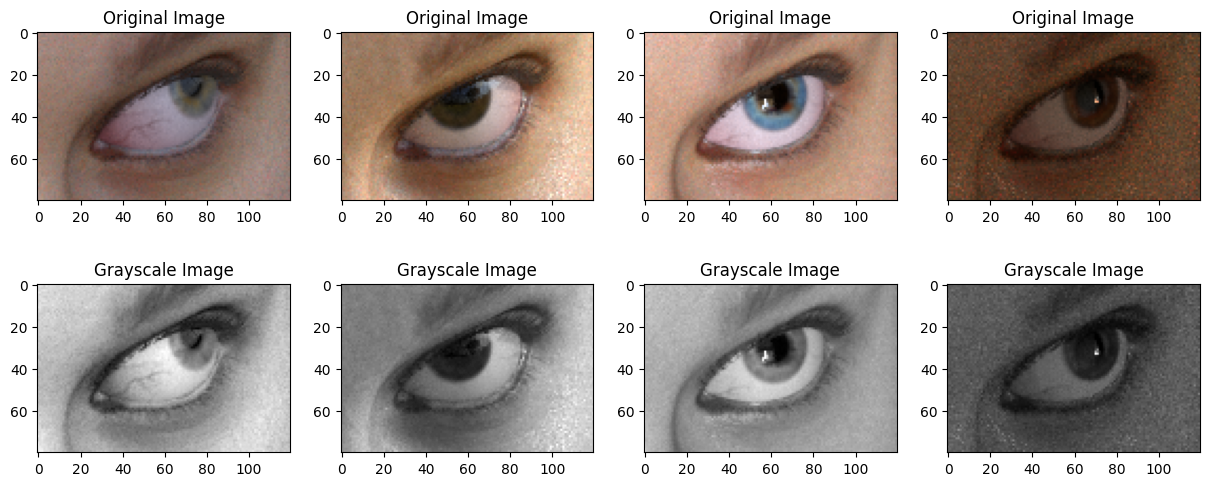

In [ ]:
images_to_read=['f01_36_0.1963_-0.7854.png','f01_42_-0.0000_-0.1963.png','f01_43_-0.0000_-0.3927.png','f01_44_-0.0000_-0.5890.png']
image_path = 'SynthEyes_data/f01/'

image = []
image_reshaped = []
gray = []

fig, axes = plt.subplots(figsize=(15, 6), ncols=4, nrows=2)
for i in range(4):
    image.append(imread(image_path+images_to_read[i]))
    image_reshaped.append(image[i][:,:,:-1])
    gray.append(rgb2gray(image_reshaped[i]))

    axes[0][i].imshow(image_reshaped[i])
    axes[0][i].set_title("Original Image")
    axes[1][i].imshow(gray[i], cmap='gray')
    axes[1][i].set_title("Grayscale Image")

100%|██████████| 4/4 [00:00<00:00, 78.46it/s]


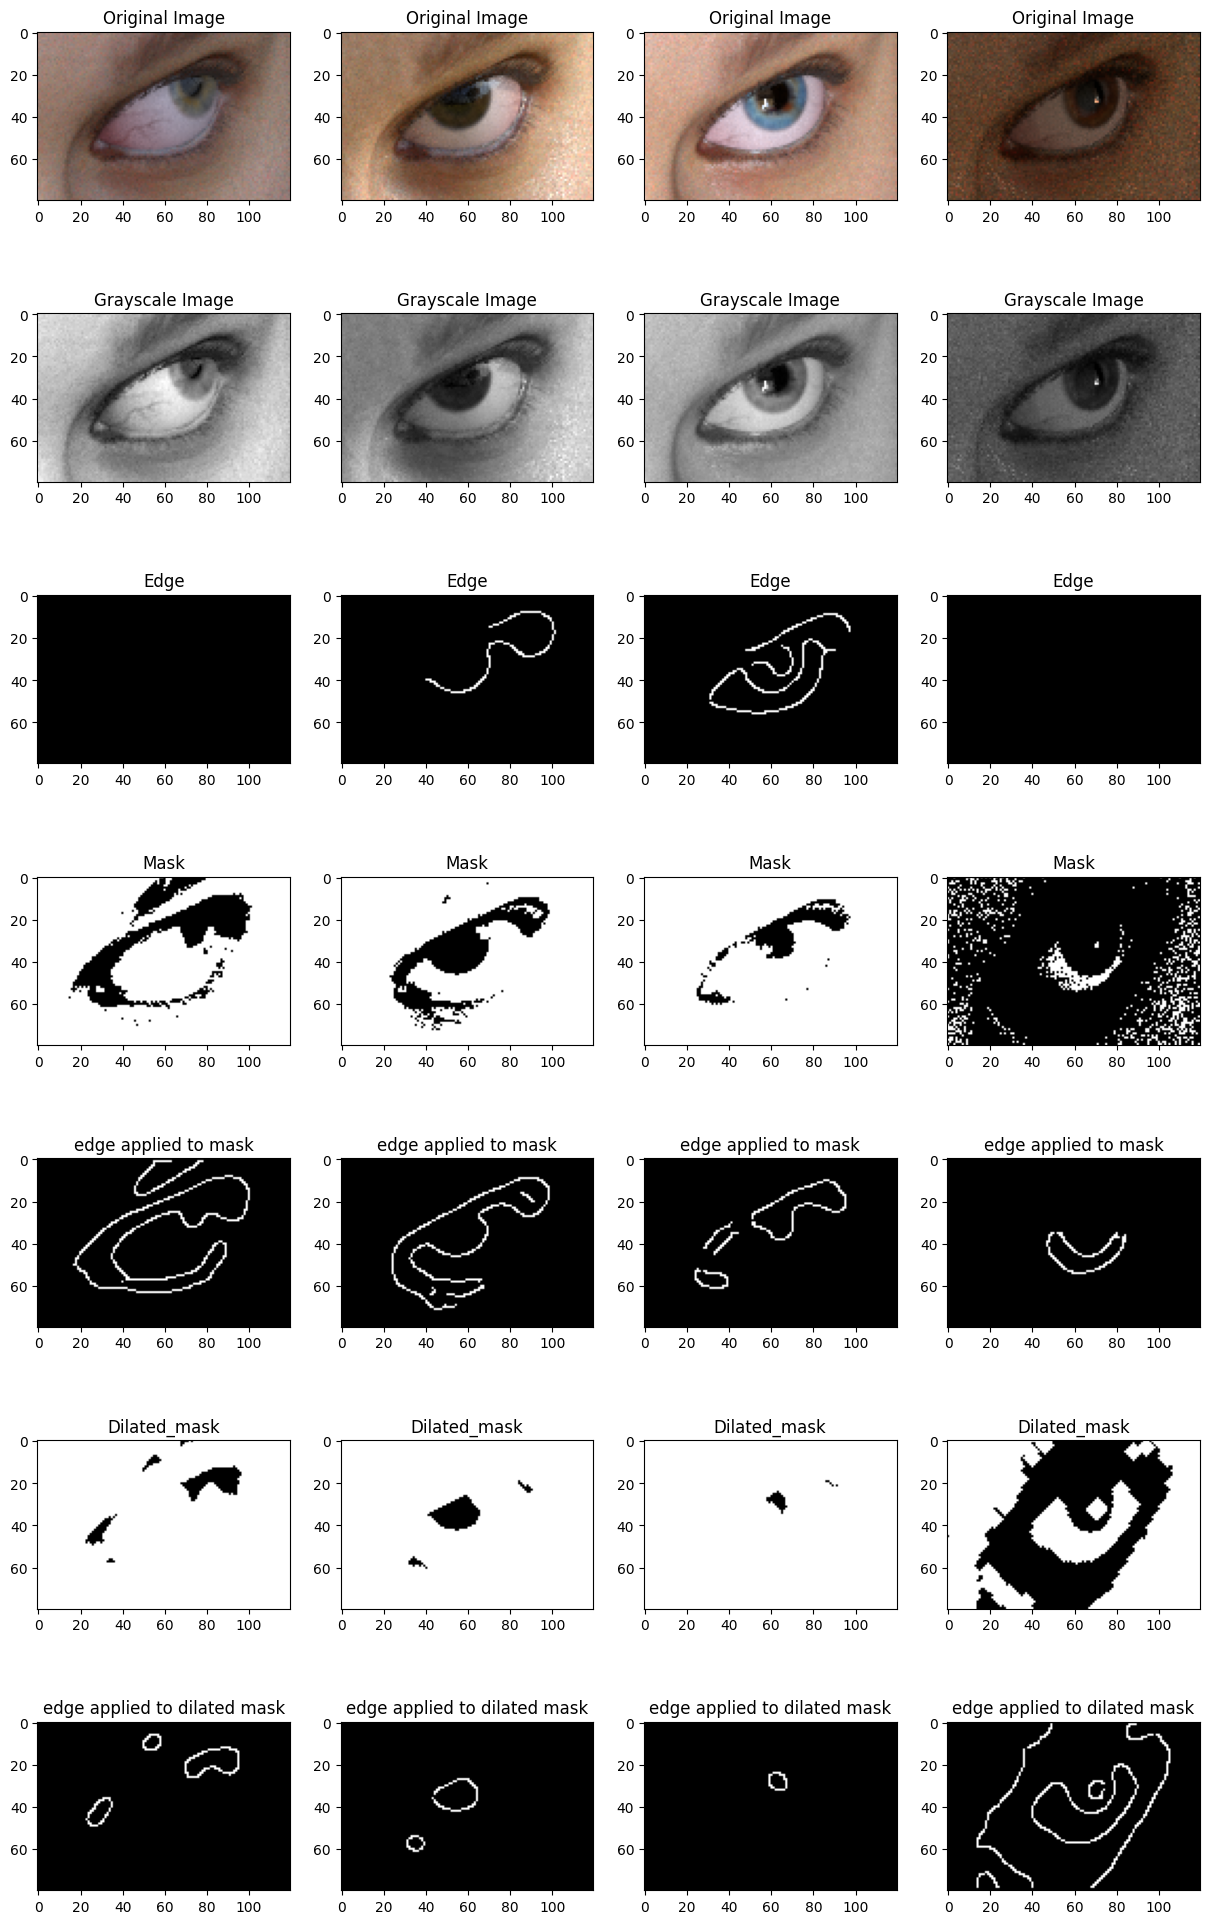

In [ ]:

edge = []
mask = []
mask_edge = []
dilated_mask = []
dilated_mask_edge = []

fig, axes = plt.subplots(figsize=(15, 25), ncols=4, nrows=7)
for i in tqdm(range(4)):
    edge.append(canny(gray[i], sigma=3, low_threshold=0.2, high_threshold=0.4))
    mask.append(mask_image(gray[i],0.3))
    mask_edge.append(canny(mask[i], sigma=3, low_threshold=0.2, high_threshold=0.4).astype(np.uint8))
    dilated_mask.append(dilated_image(mask[i], 4))
    dilated_mask_edge.append(canny(dilated_mask[i], sigma=3, low_threshold=0.2, high_threshold=0.4).astype(np.uint8))

    axes[0][i].imshow(image_reshaped[i])
    axes[0][i].set_title("Original Image")
    axes[1][i].imshow(gray[i], cmap='gray')
    axes[1][i].set_title("Grayscale Image")
    axes[2][i].imshow(edge[i], cmap='gray')
    axes[2][i].set_title("Edge")
    axes[3][i].imshow(mask[i], cmap='gray')
    axes[3][i].set_title("Mask")
    axes[4][i].imshow(mask_edge[i], cmap='gray')
    axes[4][i].set_title("edge applied to mask")
    axes[5][i].imshow(dilated_mask[i], cmap='gray')
    axes[5][i].set_title("Dilated_mask")
    axes[6][i].imshow(dilated_mask_edge[i], cmap='gray')
    axes[6][i].set_title("edge applied to dilated mask")

  0%|          | 0/4 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 4/4 [00:02<00:00,  1.88it/s]


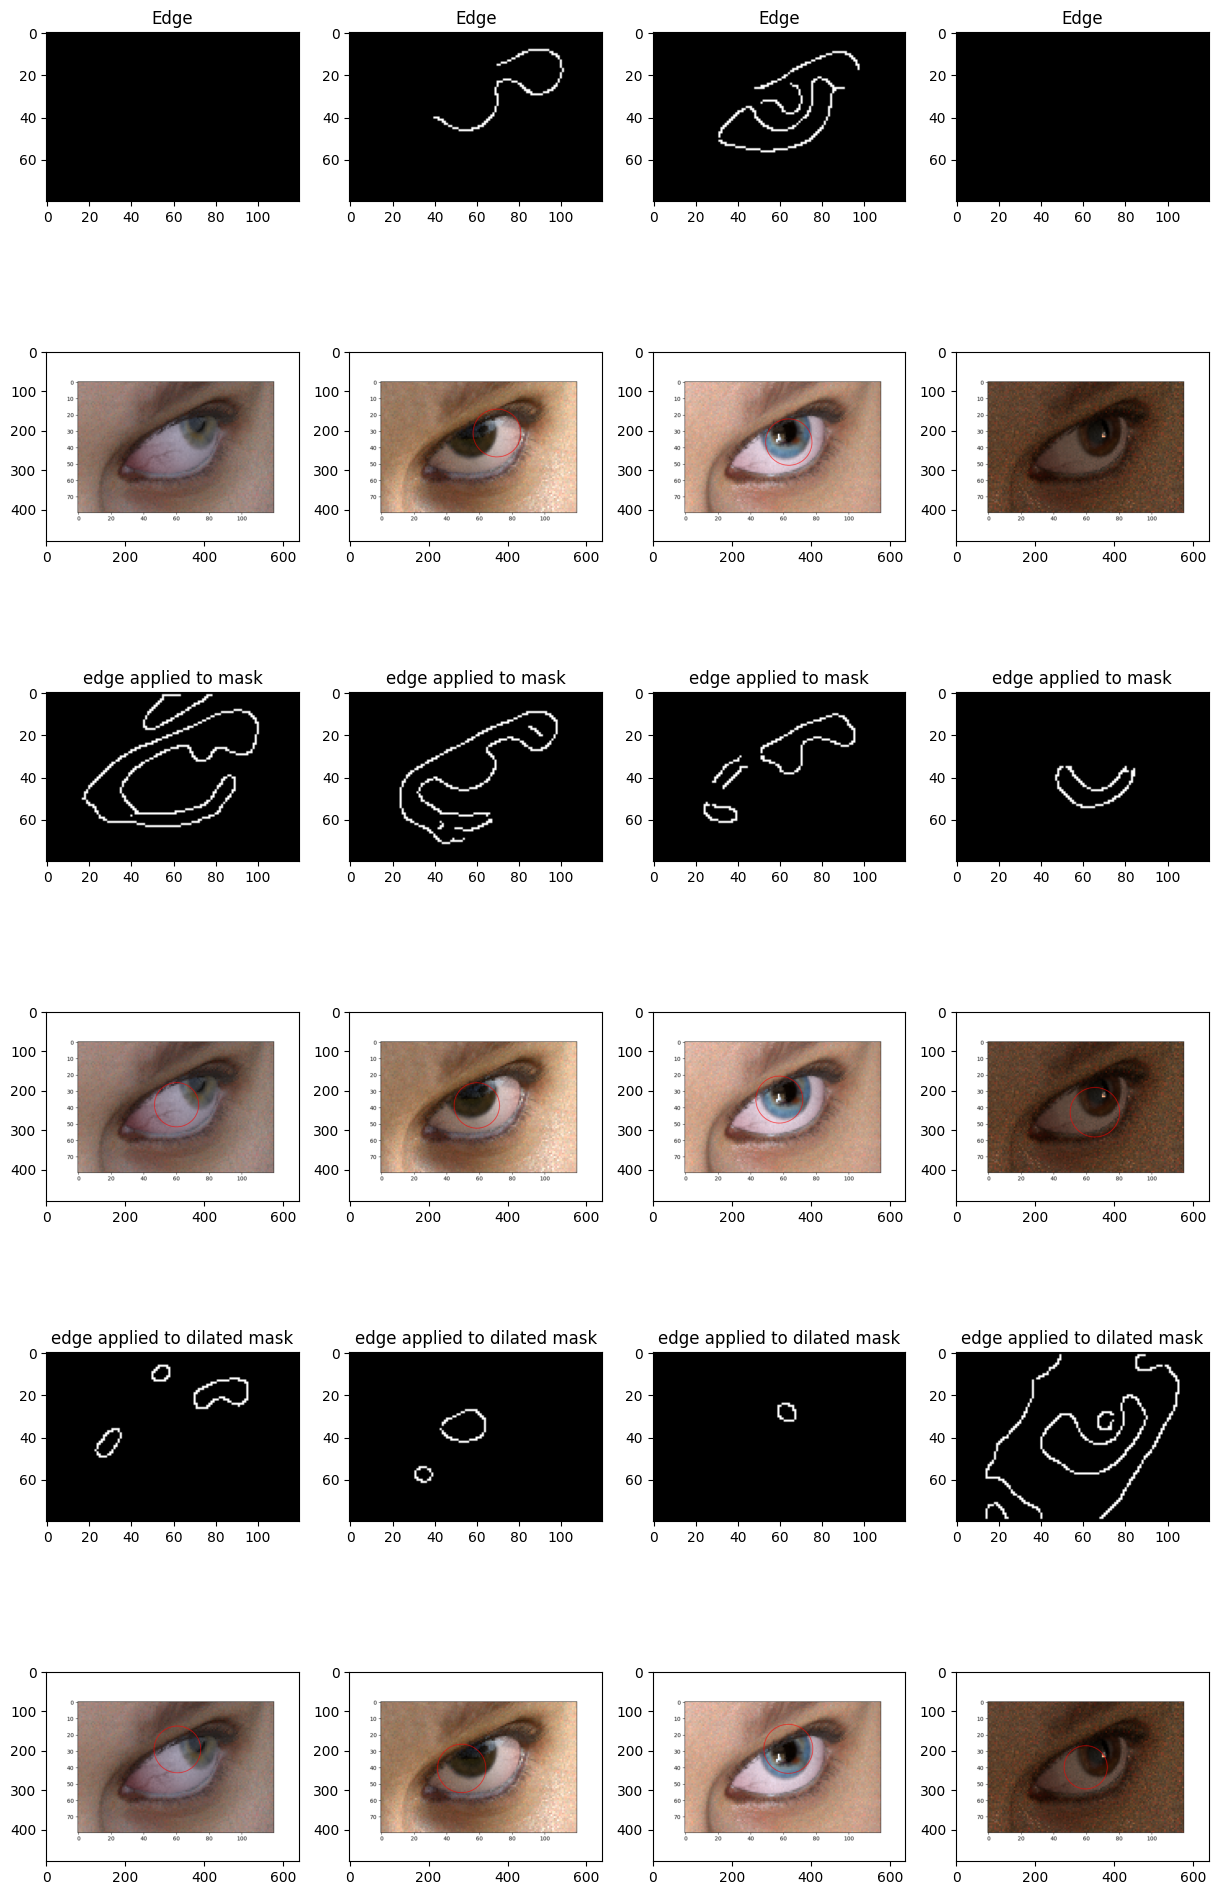

In [ ]:
coor_edge = []
coor_edge_mask = []
coor_edge_dilated_mask = []
disp_edge = []
disp_edge_mask = []
disp_edge_dilated_mask = []

fig, axes = plt.subplots(figsize=(15, 25), ncols=4, nrows=6)
for i in tqdm(range(4)):
    coor_edge.append(hough_circle(edge[i], np.arange(5, 30)))
    coor_edge_mask.append(hough_circle(mask_edge[i], np.arange(5, 30)))
    coor_edge_dilated_mask.append(hough_circle(dilated_mask_edge[i], np.arange(5, 30)))

    disp_edge.append(NewdisplayCircles(image_reshaped[i], coor_edge[i], "edge_circle_{}.png".format(i)))
    disp_edge_mask.append(NewdisplayCircles(image_reshaped[i], coor_edge_mask[i], "edge_mask_circle_{}.png".format(i)))
    disp_edge_dilated_mask.append(NewdisplayCircles(image_reshaped[i], coor_edge_dilated_mask[i], "edge_dilated_mask_circle_{}.png".format(i)))

    axes[0][i].imshow(edge[i], cmap='gray')
    axes[0][i].set_title("Edge")
    axes[1][i].imshow(disp_edge[i])
    axes[2][i].imshow(mask_edge[i], cmap='gray')
    axes[2][i].set_title("edge applied to mask")
    axes[3][i].imshow(disp_edge_mask[i])
    axes[4][i].imshow(dilated_mask_edge[i], cmap='gray')
    axes[4][i].set_title("edge applied to dilated mask")
    axes[5][i].imshow(disp_edge_dilated_mask[i])

 25%|██▌       | 1/4 [00:00<00:02,  1.38it/s]

[array([17.        , 91.        , 12.44444444])]


 50%|█████     | 2/4 [00:01<00:01,  1.40it/s]

[array([17.        , 91.        , 12.44444444]), array([35.        , 55.        , 14.33333333])]


 75%|███████▌  | 3/4 [00:02<00:00,  1.41it/s]

[array([17.        , 91.        , 12.44444444]), array([35.        , 55.        , 14.33333333]), array([28.        , 62.        , 10.55555556])]


100%|██████████| 4/4 [00:02<00:00,  1.41it/s]

[array([17.        , 91.        , 12.44444444]), array([35.        , 55.        , 14.33333333]), array([28.        , 62.        , 10.55555556]), array([nan, nan, nan])]


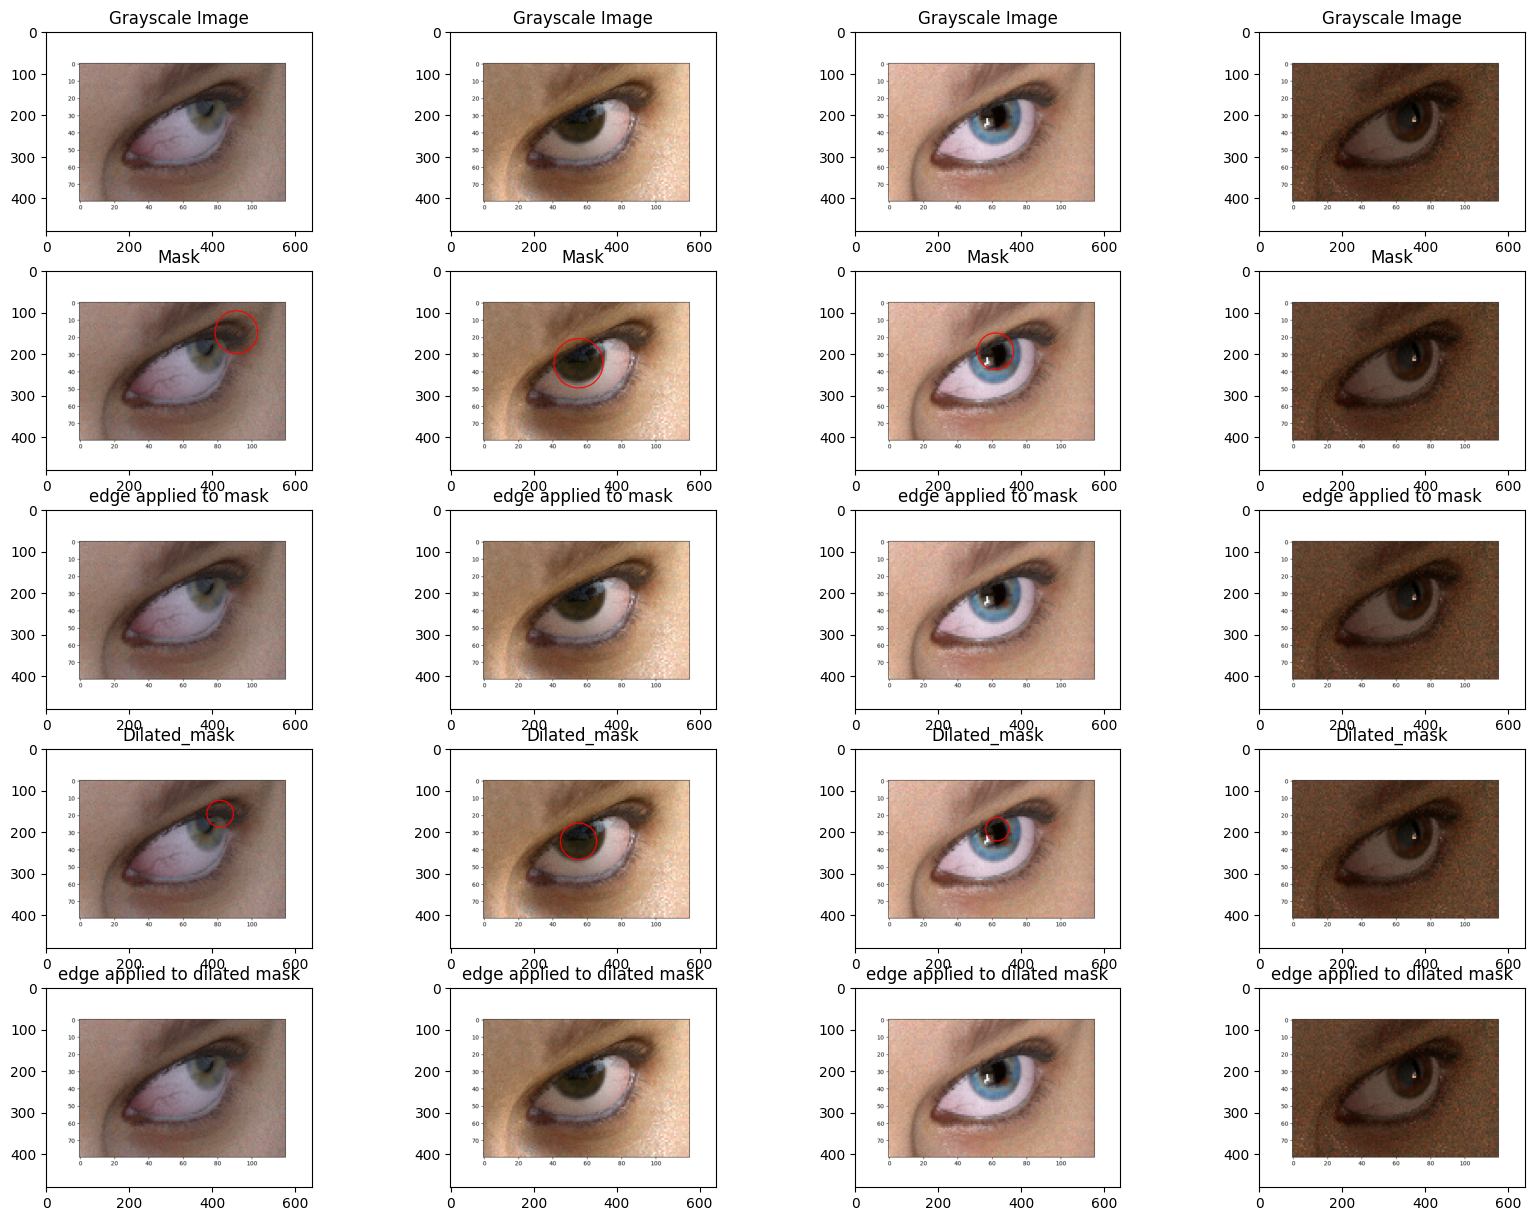

In [ ]:
gray_blob = []
edge_blob = []
mask_blob = []
mask_edge_blob = []
dilated_mask_blob = []
dilated_mask_edge_blob = []

disp_gray_blob = []
disp_edge_blob = []
disp_mask_blob = []
disp_mask_edge_blob = []
disp_dilated_mask_blob = []
disp_dilated_mask_edge_blob = []

coor_blob = []

fig, axes = plt.subplots(figsize=(20, 15), ncols=4, nrows=5)
for i in tqdm(range(4)):
    
    gray_blob.append(blob_doh(gray[i], max_sigma=20, min_sigma=3, threshold=.05))
    mask_blob.append(blob_doh(mask[i], max_sigma=20, min_sigma=3, threshold=.05))
    mask_edge_blob.append(blob_doh(mask_edge[i], max_sigma=20, min_sigma=3, threshold=.05))
    dilated_mask_blob.append(blob_doh(dilated_mask[i], max_sigma=20, min_sigma=3, threshold=.05))
    dilated_mask_edge_blob.append(blob_doh(dilated_mask_edge[i], max_sigma=20, min_sigma=3, threshold=.05))

    coor_blob.append(New_output_coor_blob(image[i], mask_blob[i],15,5))

    disp_gray_blob.append(NewdisplayBlob(image_reshaped[i], gray_blob[i], "gray_blob_{}.png".format(i),15,5))
    disp_mask_blob.append(NewdisplayBlob(image_reshaped[i], mask_blob[i], "gray_blob_{}.png".format(i),15,5))
    disp_mask_edge_blob.append(NewdisplayBlob(image_reshaped[i], mask_edge_blob[i], "gray_blob_{}.png".format(i),15,5))
    disp_dilated_mask_blob.append(NewdisplayBlob(image_reshaped[i], dilated_mask_blob[i], "gray_blob_{}.png".format(i),15,5))
    disp_dilated_mask_edge_blob.append(NewdisplayBlob(image_reshaped[i], dilated_mask_edge_blob[i], "gray_blob_{}.png".format(i),15,5))


    # disp_gray_blob.append(displayBlob(image_reshaped[i], gray_blob[i], "gray_blob_{}.png".format(i),20,5))
    # disp_mask_blob.append(displayBlob(image_reshaped[i], mask_blob[i], "gray_blob_{}.png".format(i),20,5))
    # disp_mask_edge_blob.append(displayBlob(image_reshaped[i], mask_edge_blob[i], "gray_blob_{}.png".format(i),20,5))
    # disp_dilated_mask_blob.append(displayBlob(image_reshaped[i], dilated_mask_blob[i], "gray_blob_{}.png".format(i),20,5))
    # disp_dilated_mask_edge_blob.append(displayBlob(image_reshaped[i], dilated_mask_edge_blob[i], "gray_blob_{}.png".format(i),20,5))

    axes[0][i].imshow(disp_gray_blob[i], cmap='gray')
    axes[0][i].set_title("Grayscale Image")
    axes[1][i].imshow(disp_mask_blob[i], cmap='gray')
    axes[1][i].set_title("Mask")
    axes[2][i].imshow(disp_mask_edge_blob[i], cmap='gray')
    axes[2][i].set_title("edge applied to mask")
    axes[3][i].imshow(disp_dilated_mask_blob[i], cmap='gray')
    axes[3][i].set_title("Dilated_mask")
    axes[4][i].imshow(disp_dilated_mask_edge_blob[i], cmap='gray')
    axes[4][i].set_title("edge applied to dilated mask")

    print(coor_blob)

In [19]:
from pathlib import Path
path = Path('SynthEyes_data/f01')
p = path.glob('**/*.png')
files = [x for x in p if x.is_file()]
num_files = len(files)
print(num_files)

1170


In [20]:
image = []
gray = []
image_reshaped = []
list_of_names = []
for i in files:
    list_of_names.append(i)
list_of_names.sort()
for i in range(len(list_of_names)):
    image.append(imread(list_of_names[i]))
    image_reshaped.append(image[i][:,:,:-1])
    gray.append(rgb2gray(image_reshaped[i]))
print(image_reshaped[0].shape)
print(len(gray))

(80, 120, 3)
1170


In [21]:

mask = []
dilated_mask = []
dilated_mask_edge = []
coor_edge_dilated_mask = []
disp_edge_dilated_mask = []
coor_circles = []

mask_blob = []
coor_blob = []


for i in tqdm(range(len(gray))):
    mask.append(mask_image(gray[i],0.3))
    # dilated_mask.append(dilated_image(mask[i], 6))
    # dilated_mask_edge.append(canny(dilated_mask[i], sigma=3, low_threshold=0.1, high_threshold=0.4).astype(np.uint8))
    # coor_edge_dilated_mask.append(hough_circle(dilated_mask_edge[i], np.arange(7, 20)))
    # disp_edge_dilated_mask.append(NewdisplayCircles(image_reshaped[i], coor_edge_dilated_mask[i], "unity_eye/circle_estimation/edge_dilated_mask_circle_{}.png".format(i)))
    # coor_circles.append(output_coor_circles(image_reshaped[i], coor_edge_dilated_mask[i]))

    mask_blob.append(blob_doh(mask[i], max_sigma=20, min_sigma=3, threshold=.05))
    # disp_mask_blob.append(NewdisplayBlob(image_reshaped[i], mask_blob[i], "unity_eye/blob_estimation/gray_blob_{}.png".format(i),15,5))
    coor_blob.append(New_output_coor_blob(image[i], mask_blob[i],15,5))

  0%|          | 0/1170 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
100%|██████████| 1170/1170 [00:08<00:00, 130.41it/s]


In [22]:
column_names = ['r','predicted_y','predicted_x']
df_coor_circles = pd.DataFrame(coor_circles, columns=column_names) #, columns = column_names)
print(df_coor_circles.head())
print(df_coor_circles.shape)
df_coor_circles = df_coor_circles.drop('r', axis=1)
print(df_coor_circles.head())
print(df_coor_circles.shape)

Empty DataFrame
Columns: [r, predicted_y, predicted_x]
Index: []
(0, 3)
Empty DataFrame
Columns: [predicted_y, predicted_x]
Index: []
(0, 2)


In [23]:
column_names = ['predicted_y','predicted_x','r']
df_coor_blob = pd.DataFrame(coor_blob, columns=column_names) #, columns = column_names)
print(df_coor_blob.head())
print(df_coor_blob.shape)
df_coor_blob = df_coor_blob.drop('r', axis=1)
df_coor_blob.to_csv('blob_1.csv')
print(df_coor_blob.head())
print(df_coor_blob.shape)


   predicted_y  predicted_x          r
0          NaN          NaN        NaN
1          NaN          NaN        NaN
2          0.0        112.0  14.333333
3          NaN          NaN        NaN
4          NaN          NaN        NaN
(1170, 3)
   predicted_y  predicted_x
0          NaN          NaN
1          NaN          NaN
2          0.0        112.0
3          NaN          NaN
4          NaN          NaN
(1170, 2)


In [24]:
from pathlib import Path
path = Path('SynthEyes_data/f01')
p = path.glob('**/*.pkl')
files = [x for x in p if x.is_file()]
num_files = len(files)
print(num_files)

1170


In [25]:
mean_x = []
mean_y = []
look_vec_x = []
look_vec_y = []
look_vec_z = []


for i in range(num_files):
    unpickled_df = pd.read_pickle(files[i])  
    x_coordinates = [tup[0] for tup in unpickled_df['ldmks']['ldmks_pupil_2d']]
    y_coordinates = [tup[1] for tup in unpickled_df['ldmks']['ldmks_pupil_2d']]
    mean_x.append(sum(x_coordinates) / len(x_coordinates))
    mean_y.append(sum(y_coordinates) / len(y_coordinates))
    look_vec_x.append(unpickled_df['look_vec'][0])
    look_vec_y.append(unpickled_df['look_vec'][1])
    look_vec_z.append(unpickled_df['look_vec'][2])


In [26]:
true_df = pd.DataFrame({'true_y': mean_y,'true_x': mean_x})
print(true_df.shape)
print(true_df.head())

look_vec_df = pd.DataFrame({'x': look_vec_x,'y': look_vec_y,'z':look_vec_z})
print(look_vec_df.shape)
print(look_vec_df.head())


(1170, 2)
      true_y     true_x
0  29.846734  54.254781
1  40.888493  44.143124
2  36.442341  43.416190
3  36.570298  66.831332
4  41.371833  73.670738
(1170, 3)
          x         y         z
0 -0.413728 -0.359217 -0.836536
1 -0.369369  0.400853 -0.838381
2 -0.732105  0.156942 -0.662866
3  0.411623 -0.382425 -0.827235
4  0.380012  0.201316 -0.902808


In [27]:
both_df = pd.concat([df_coor_circles, true_df,look_vec_df], axis=1)
both_df = both_df.dropna()
print(both_df.shape)

(0, 7)


In [28]:
both_df = pd.concat([df_coor_blob, true_df,look_vec_df], axis=1)
both_df = both_df.dropna()
print(both_df.shape)

both_df = both_df[both_df['predicted_x'] <= 100]
both_df = both_df[both_df['predicted_x'] >= 20]
both_df = both_df[both_df['predicted_y'] <= 70]
both_df = both_df[both_df['predicted_y'] >= 10]
print(both_df.shape)
print(both_df.head())

(170, 7)
(101, 7)
    predicted_y  predicted_x     true_y     true_x         x         y  \
6          28.0         57.0  33.047344  45.143771 -0.571037 -0.156602   
18         46.0         49.0  35.094598  66.299998  0.606777  0.186746   
20         50.0         49.0  52.914726  41.634450 -0.557672  0.311212   
39         43.0         73.0  44.714579  53.932205 -0.197962  0.410094   
41         45.0         66.0  32.481009  66.338455  0.604064  0.019537   

           z  
6  -0.805849  
18 -0.772624  
20 -0.769512  
39 -0.890300  
41 -0.796696  


In [29]:
df_coor_circles = both_df[['predicted_y','predicted_x']]
print(df_coor_circles.head())

true_df = both_df[['true_y','true_x']]
print(true_df.head())

look_vec_df = both_df[['x','y','z']]
print(look_vec_df.head())

    predicted_y  predicted_x
6          28.0         57.0
18         46.0         49.0
20         50.0         49.0
39         43.0         73.0
41         45.0         66.0
       true_y     true_x
6   33.047344  45.143771
18  35.094598  66.299998
20  52.914726  41.634450
39  44.714579  53.932205
41  32.481009  66.338455
           x         y         z
6  -0.571037 -0.156602 -0.805849
18  0.606777  0.186746 -0.772624
20 -0.557672  0.311212 -0.769512
39 -0.197962  0.410094 -0.890300
41  0.604064  0.019537 -0.796696


In [30]:
df_coor_blob = both_df[['predicted_y','predicted_x']]
print(df_coor_blob.head())

true_df = both_df[['true_y','true_x']]
print(true_df.head())

look_vec_df = both_df[['x','y','z']]
print(look_vec_df.head())

    predicted_y  predicted_x
6          28.0         57.0
18         46.0         49.0
20         50.0         49.0
39         43.0         73.0
41         45.0         66.0
       true_y     true_x
6   33.047344  45.143771
18  35.094598  66.299998
20  52.914726  41.634450
39  44.714579  53.932205
41  32.481009  66.338455
           x         y         z
6  -0.571037 -0.156602 -0.805849
18  0.606777  0.186746 -0.772624
20 -0.557672  0.311212 -0.769512
39 -0.197962  0.410094 -0.890300
41  0.604064  0.019537 -0.796696


In [31]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score

def metric(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    evs = explained_variance_score(y_true, y_pred)
    metrics=[mae,mse,rmse,r2,evs]
    return metrics

In [32]:
metric(true_df, df_coor_circles)

[12.229404697176253,
 270.6476927841718,
 16.45137358350882,
 -2.1742837775276374,
 -1.885862512886952]

In [33]:
metric(true_df, df_coor_blob)

[12.229404697176253,
 270.6476927841718,
 16.45137358350882,
 -2.1742837775276374,
 -1.885862512886952]

In [37]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

# define the regressor
regressor = [RandomForestRegressor(),LinearRegression(),Ridge(),Lasso(),DecisionTreeRegressor(),SVR(),MLPRegressor()]

def machine_learn(X_test,regressor, X_train=true_df, y_train=look_vec_df):
    # define the multi-output regressor
    multi_output = MultiOutputRegressor(regressor)
    # fit the model
    multi_output.fit(X_train, y_train)
    # predict
    y_pred = multi_output.predict(X_test)
    score = multi_output.score(X_test, y_pred)
    return score, y_pred

In [38]:
score = []
pred = []
for i in range(len(regressor)):
    score.append(machine_learn(df_coor_blob,regressor[i])[0])
    pred.append(machine_learn(df_coor_blob,regressor[i])[1])

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predicted_x
- predicted_y
Feature names seen at fit time, yet now missing:
- true_x
- true_y

  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names unseen at fit time:
- predicted_x
- predicted_y
Feature names seen at fit time, yet now missing:
- true_x
- true_y

  warnings.warn(message, FutureWarning)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an e

In [36]:
print(score)

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [39]:
print(pred)

[array([[ 0.22434682, -0.46976314, -0.81943872],
       [-0.51336061,  0.1929718 , -0.80568847],
       [-0.49430058,  0.2364579 , -0.80817114],
       [ 0.44463893,  0.24106431, -0.83013806],
       [ 0.53486479,  0.23210838, -0.80026974],
       [ 0.19419606,  0.23210415, -0.82525725],
       [ 0.3828335 , -0.28671153, -0.88576982],
       [ 0.34307817, -0.27730775, -0.8905169 ],
       [ 0.45820322, -0.14993898, -0.85819061],
       [-0.17663087,  0.24054271, -0.88470308],
       [ 0.45820322, -0.14993898, -0.85819061],
       [-0.38351988,  0.3775396 , -0.79216275],
       [-0.26610274,  0.28807035, -0.8419938 ],
       [-0.3628878 ,  0.38007019, -0.83499771],
       [ 0.43946006,  0.01854805, -0.84924297],
       [-0.19497646,  0.17373076, -0.87272796],
       [ 0.47369191,  0.36861395, -0.79554472],
       [ 0.39310663, -0.11196609, -0.85376498],
       [-0.24201494,  0.33905208, -0.87000551],
       [ 0.35975077, -0.11532666, -0.8553505 ],
       [ 0.40023425, -0.14246623, -0.85